In [ ]:
# 25 marks

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.datasets import fetch_california_housing
import pymc3 as pm
import arviz as az

In [15]:
# Load California housing dataset

california_housing = fetch_california_housing(as_frame=True)
x = california_housing.data.head().T
print(x.shape)
y = california_housing.target.head()
print(y.shape)

(8, 5)
(5,)


/var/folders/8g/b7_xy_gx7ysgvrt10qyzhv7c0000gn/T/ipykernel_92643/1658626609.py:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  posterior = pm.sample(num_samples, sampler, progressbar=True, cores=2, chains=2)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, w1, w0]


/Users/lucy/opt/anaconda3/envs/ML_labs/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/lucy/opt/anaconda3/envs/ML_labs/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
w0     3.698  0.074   3.560    3.838      0.002    0.001    1878.0    1298.0   
w1    -0.000  0.000  -0.000    0.000      0.000    0.000    2188.0    1434.0   
sigma  0.446  0.053   0.356    0.546      0.001    0.001    1986.0    1300.0   

       r_hat  
w0       1.0  
w1       1.0  
sigma    1.0  


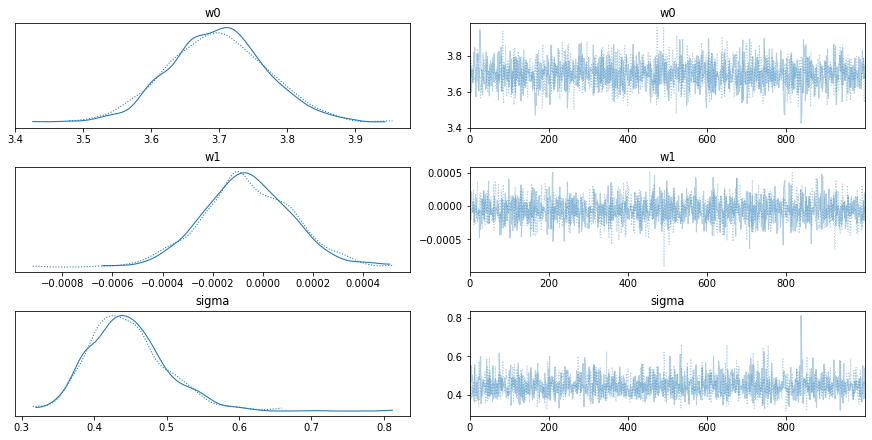

In [16]:
# Use PyMC to get approximate posterior distributions over each model parameter

num_samples = 1000
model = pm.Model()

with model:
    # Defining our priors
    w0 = pm.Normal('w0', mu=0, sigma=20)
    w1 = pm.Normal('w1', mu=0, sigma=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)

    y_est = w0 + w1*x # auxiliary variables

    likelihood = pm.Normal('y', mu=y_est, sigma=sigma, observed=y)
    
    # inference
    sampler = pm.NUTS() # Hamiltonian MCMC with No U-Turn Sampler 
    # or alternatively
    # sampler = pm.Metropolis()
    
    posterior = pm.sample(num_samples, sampler, progressbar=True, cores=2, chains=2)
    print(az.summary(posterior))
    az.plot_trace(posterior)
    plt.show()